(binary-pump-example)=
# Binary pumps

This example is available in the following formats:

- YAML
    - [basic_pump.yaml](basic-pump-yaml)
- ASCII
    - [basic_pump.ascii](basic-pump-ascii)

pyshop code for adding pump is provided below, while the initial model is available in [basic_pump.py](basic-pump-py).

## Introduction

This example imports a basic model and adds a simple binary [pump](pump). By varying the sale price in the [market](market), we see that the watercourse pumps water to the upper [reservoir](reservoir) when the price is lower than its water value.

## Imports

In [1]:
#Necessary imports used in all examples
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px

from pyshop import ShopSession

#Functions used in this example for building a basic SHOP model and running it
from basic_pump import build_model, run_model

## Create a SHOP session and import basic model from file function

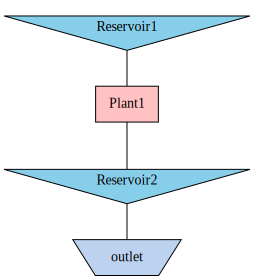

In [2]:
#Create a standard ShopSession
shop=ShopSession()
#Build a basic SHOP model
build_model(shop)
#Display topology to the screen
display(shop.model.build_connection_tree())

## Add pumping capabilities

Pumps can be added as pump objects, and need to be connected to a [plant](plant). We then apply attributes to the pump object. A binary pump only has a single operating point, which is specified by only supplying a single point in the [turbine efficiency curves](pump:turb_eff_curves). Note that the point may still change as a function of head. If the [p_min](pump:p_min) and [p_max](pump:p_max) attributes of the binary pump are set to be equal, the pump will always consume this amount of power. If the operation of the pump should only be constrained by the points defined in the turbine efficiency curves, p_min and p_max can be set to unconstraining values such as 0 and 10000, respectively. In the example below, consumption will also be bounded to be within 38 and 42 MW. Whereas you in the old ASCII format don't need to specify a maximum and minimum production for a binary pump, you need to explicitly add those attributes in addition to the nominal production in pyshop.

In [3]:
p1p1=shop.model.pump.add_object("P1P1")
p1p1.connect_to(shop.model.plant.Plant1)
p1p1.penstock.set(1)
p1p1.p_nom.set(40)
p1p1.p_min.set(38)
p1p1.p_max.set(42)
p1p1.startcost.set(500)
p1p1.gen_eff_curve.set(pd.Series([100,100], index=[0,50]))
p1p1.turb_eff_curves.set([pd.Series([87],index=[80],name=40),pd.Series([86],index=[70],name=50),pd.Series([85],index=[60],name=60)])

## Run SHOP

In [4]:
run_model(shop)

## Plots and results

We observe that the pump is used in the first six hours of the period, where the market price is lower than the water value in the upper reservoir.

In [5]:
# Plot market price and water value of reservoirs
spot_price=shop.model.market.Day_Ahead.sale_price.get()

fig = go.Figure()
colorscale = px.colors.sequential.RdBu_r
color = 1
fig.add_trace(go.Scatter(x=spot_price.index, marker_color = colorscale[color], y=spot_price.values, name="Market price"))

for rsv in shop.model.reservoir:
    color+=1
    end_water_value=rsv.energy_value_input.get()
    water_value=pd.Series([end_water_value]*len(spot_price),index=spot_price.index)
    curve_name="Water value of "+rsv.get_name()
    fig.add_trace(go.Scatter(x=water_value.index, y=water_value.values, marker_color = colorscale[color], name=curve_name, line=dict(dash="dot")))
    
fig.update_layout(title="<b>Market price and water value of reservoirs</b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Price</b> (€/MWh)")

fig.show()

In [6]:
# Plotting pump consumption and generator production
p1p1_consumption=shop.model.pump.P1P1.consumption.get()
p1g1_production=shop.model.generator.P1G1.production.get()
fig = go.Figure()
colorscale = px.colors.sequential.Magenta
fig.add_trace(go.Bar(x=p1p1_consumption.index, y=p1p1_consumption.values, name="Pump consumption", marker_color=colorscale[1]))
fig.add_trace(go.Bar(x=p1g1_production.index, y=p1g1_production.values, name="Generator production", marker_color=colorscale[6]))
fig.update_layout(title="<b>Pump consumption and generator production</b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Production/Consumption</b> (MW)")

In [7]:
# Plotting reservoir trajectories
water_storage_rsv1=shop.model.reservoir.Reservoir1.storage.get()
water_storage_rsv2=shop.model.reservoir.Reservoir2.storage.get()
fig = go.Figure()
colorscale = px.colors.sequential.RdBu_r
fig.add_trace(go.Scatter(x=water_storage_rsv1.index, y=water_storage_rsv1.values, name="Reservoir1 storage", marker_color=colorscale[1],fill='tozeroy'))
fig.add_trace(go.Scatter(x=water_storage_rsv2.index, y=water_storage_rsv2.values, name="Reservoir2 storage", marker_color=colorscale[2],fill='tozeroy'))
fig.update_layout(title="<b>Reservoir trajectories </b>", xaxis_title="<b>Time</b> (Hour)", yaxis_title="<b>Volume</b> (Mm<sup>3</sup>)")
fig.show()

# File contents

(basic-pump-py)=
## basic_pump.py <a name="tunnel_model.py"></a>

In [8]:
with open('basic_pump.py', 'r') as f:
    print(f.read())

import pandas as pd

def build_model(shop):
    starttime=pd.Timestamp("2018-02-27 00:00:00")
    endtime=pd.Timestamp("2018-02-28 00:00:00")
    shop.set_time_resolution(starttime=starttime, endtime=endtime, timeunit="hour")

    rsv1=shop.model.reservoir.add_object("Reservoir1")
    rsv1.hrl.set(100)
    rsv1.lrl.set(90)
    rsv1.max_vol.set(12)
    rsv1.vol_head.set(pd.Series([90,100,101],index=[0,12,14]))

    plant1=shop.model.plant.add_object("Plant1")
    plant1.main_loss.set([0.0002])
    plant1.penstock_loss.set([0.0001])
    plant1.outlet_line.set(40)

    p1g1=shop.model.generator.add_object("P1G1")
    p1g1.connect_to(plant1)
    p1g1.penstock.set(1)
    p1g1.p_min.set(25)
    p1g1.p_nom.set(100)
    p1g1.p_max.set(100)
    p1g1.startcost.set(500)
    p1g1.gen_eff_curve.set(pd.Series([95,98], index=[0,100]))
    p1g1.turb_eff_curves.set([pd.Series([80,95,90],index=[25,90,100],name=90),pd.Series([82,98,92],index=[25,90,100],name=100)])

    rsv2=shop.model.reservoir.add_obje

(basic-pump-yaml)=
## basic_pump.yaml <a name="tunnel_model.yaml"></a>

In [9]:
shop.dump_yaml(file_path='basic_pump.yaml',input_only=True)

with open('basic_pump.yaml', 'r') as f:
    print(f.read())

time:
  starttime: 2018-02-27 00:00:00
  endtime: 2018-02-28 00:00:00
  timeunit: hour
  timeresolution:
    2018-02-27 00:00:00: 1
model:
  reservoir:
    Reservoir1:
      max_vol: 12
      lrl: 90
      hrl: 100
      vol_head:
        ref: 0
        x:
          - 0
          - 12
          - 14
        y:
          - 90
          - 100
          - 101
      start_head: 92
      inflow:
        2018-02-27 00:00:00: 10
      energy_value_input: 39.7
    Reservoir2:
      max_vol: 5
      lrl: 40
      hrl: 50
      vol_head:
        ref: 0
        x:
          - 0
          - 5
          - 6
        y:
          - 40
          - 50
          - 51
      start_head: 43
      inflow:
        2018-02-27 00:00:00: 0
  plant:
    Plant1:
      outlet_line: 40
      main_loss:
        - 0.0002
      penstock_loss:
        - 0.0001
  generator:
    P1G1:
      penstock: 1
      p_min: 25
      p_max: 100
      p_nom: 100
      gen_eff_curve:
        ref: 0
        x:
          - 0
         

(basic-pump-ascii)=
## basic_pump.ascii <a name="tunnel_model.ascii"></a>

In [10]:
with open('basic_pump.ascii', 'r') as f:
    print(f.read())

OPTIMIZATION time
#Start_time End_time Time_unit
20180227000000 20180228000000 HOUR

OPTIMIZATION time_resolution
#Id Number Start_Time Time_unit Period Data_type Y_unit Pts
0 0 20180227000000 HOUR 876000000 -1 HOUR 1
#time y_value
20180227000000000 1

RESERVOIR declaration Reservoir1

RESERVOIR max_vol Reservoir1
12

RESERVOIR lrl Reservoir1
90

RESERVOIR hrl Reservoir1
100

RESERVOIR vol_head Reservoir1
#Id Number Referance Pts X_unit Y_unit
0 0 0 3 MM3 METER
#x_values y_value
0  90
12 100
14 101

RESERVOIR start_head Reservoir1
92

RESERVOIR inflow Reservoir1
#Id Number Start_Time Time_unit Period Data_type Y_unit Pts
0 0 20180227000000000 HOUR 876000000 -1 M3/S 1
#time y_value
20180227000000000 10

RESERVOIR energy_value_input Reservoir1
39.7

RESERVOIR declaration Reservoir2

RESERVOIR max_vol Reservoir2
5

RESERVOIR lrl Reservoir2
40

RESERVOIR hrl Reservoir2
50

RESERVOIR vol_head Reservoir2
#Id Number Referance Pts X_unit Y_unit
0 0 0 3 MM3 METER
#x_values y_value
0 40
5 50
6 5